In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.ticker as ticker
from matplotlib import  rcParams
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import pandas as pd
import sqlite3
import seaborn as sns


In [2]:
rcParams["text.usetex"] = True
rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16
rcParams["axes.labelcolor"] = "black"
rcParams["figure.constrained_layout.use"] = True
rcParams["axes.titlesize"] = 22
rcParams["axes.facecolor"] = "white"
rcParams["axes.labelsize"] = 21
rcParams["legend.facecolor"] = "white"
rcParams["legend.edgecolor"] = "black"
rcParams['font.family'] = 'serif'

conn = sqlite3.connect('../results/results.db')
cursor = conn.cursor()

In [3]:
def format_ticks(ax, threshold=1000):
    """
    Formatea los ticks de una gráfica para mostrar números con una "k" si superan el límite especificado.
    
    Args:
        ax (matplotlib.axes._subplots.AxesSubplot): Eje de la gráfica.
        threshold (int): Límite para mostrar los ticks con una "k". Por defecto es 1000.
    """
    def formatter(x, pos):
        if x >= threshold:
            return f'{np.round(x/1000,2)}k'
        else:
            return x
    for axis in [ax.xaxis]:
        axis.set_major_formatter(ticker.FuncFormatter(formatter))

def get_pdf(data1, data2, number, xlim=None):
    """
    Genera las distribuciones de probabilidad de densidad para los conjuntos de datos 1 y 2.
    Args:
        data1 (array-like): Conjunto de datos 1.
        data2 (array-like): Conjunto de datos 2.
        number (int): Número de puntos en el eje x para generar las distribuciones de probabilidad.
        xlim (tuple): Limites del eje x para generar las distribuciones de probabilidad. Por defecto es None.
        
    Returns:
        tuple: tupla con las distribuciones de probabilidad de densidad para los conjuntos de datos 1 y 2, y los valores del eje x.
        """
    kernel1 = stats.gaussian_kde(data1)
    kernel2 = stats.gaussian_kde(data2)
    x = np.linspace(
        np.min(np.hstack((data1, data2))) - np.std(np.hstack((data1, data2))), 
        np.max(np.hstack((data1, data2)))+ np.std(np.hstack((data1, data2))), 
        number) if xlim is None else np.linspace(xlim[0], xlim[1], number)
        
    pdf1 = kernel1.pdf(x)
    pdf2 = kernel2.pdf(x)
    return pdf1 / pdf1.sum(), pdf2 / pdf2.sum(), x

def plot_pdf_indices(df1, df2, df1label='Audiomoth', df2label='SM4', points=100, colors=['#009473','#FF6F61']):
    """
    Genera una gráfica de las distribuciones de probabilidad de densidad para cada columna especificada en cols.
        
    Args:
        df1 (DataFrame): DataFrame con los datos para el conjunto de datos 1.
        df2 (DataFrame): DataFrame con los datos para el conjunto de datos 2.
        df1label (str): Etiqueta para el conjunto de datos 1 en la leyenda de la gráfica.
        df2label (str): Etiqueta para el conjunto de datos 2 en la leyenda de la gráfica.
        points (int): Número de puntos en el eje x para generar las distribuciones de probabilidad.
        colors (list): Lista de colores para graficar cada distribución de probabilidad.
    Returns:
        tuple: tupla con los objetos `figure` y `axis` generados por matplotlib.pyplot.
        """
        
    fig, axs = plt.subplots(2, 4, figsize=(14, 7))
    ax = axs.ravel()
    for i, index in enumerate(df1.columns):
        pdf1, pdf2, x = get_pdf(df1[index],df2[index],points,xlim=None)

        ax[i].plot(x, pdf1, label=df1label, color=colors[0], linewidth = 2)
        l1 = ax[i].fill_between(x, np.zeros(len(x)), pdf1, color=colors[0], alpha=0.5, label=df1label)

        ax[i].plot(x, pdf2, label=df2label, color=colors[1], linewidth = 2)
        l2 = ax[i].fill_between(x, np.zeros(len(x)), pdf2, color=colors[1], alpha=0.5, label=df2label)
            
        ax[i].set_title(index.upper())
        ax[i].set_box_aspect(1)
        format_ticks(ax[i])
        ax[i].xaxis.set_major_locator(ticker.LinearLocator(3))
        ax[i].yaxis.set_major_locator(ticker.LinearLocator(4))
        ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        ax[i].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax[i].spines[:].set_color("black")
        ax[i].set_ylim(0.00,None)
        ax[i].set_facecolor("white")
                
            
        if np.max(x) >= 1000:
            format_ticks(ax[i])

        if i >= 4:
            ax[i].set_xlabel("Index Value")

    ax[0].set_ylabel("Probability")
    ax[4].set_ylabel("Probability")
    labels = [df1label, df2label]
    fig.legend((l1, l2), labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(labels),fontsize=22)
    plt.show()

def blob2df(df_blob, cols=None):
    df = df_blob.apply(pickle.loads).apply(pd.Series)
    df = df[df.columns[2:]]
    if cols != None:
        df.columns = COLS
    return df

In [4]:
# Corrigiendo la función para asignar colores correctamente

def create_advanced_boxplot_subplots(dataframes, titles,indices = None, figsize=(20, 20), font_size=12, palette="Set2"):
    """
    Crea un boxplot avanzado y estilizado para comparar múltiples DataFrames, 
    con un subplot para cada variable.

    :param dataframes: Lista de DataFrames para graficar.
    :param titles: Lista de títulos para cada DataFrame.
    :param figsize: Tamaño de la figura.
    :param font_size: Tamaño de la fuente.
    :param palette: Paleta de colores para los boxplots.
    """
    # Establecer el estilo del gráfico
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': font_size})

    # Variables para el boxplot
    # Variables para el boxplot
    if indices is None:
        variables = dataframes[0].columns
    else:
        variables = indices
    num_variables = len(variables)

    # Crear subplots
    fig, axes = plt.subplots(1, num_variables, figsize=figsize)

    for i, ax in enumerate(axes):
        column = variables[i]
        # Preparar los datos para cada columna
        plot_data = [df[column] for df in dataframes]
        
        # Dibujar los boxplots con los colores especificados
        boxplots = ax.boxplot(plot_data, widths=0.6, patch_artist=True)

        # Asignar colores a cada boxplot
        for boxplot, color in zip(boxplots['boxes'], sns.color_palette(palette, len(plot_data))):
            boxplot.set_facecolor(color)

        # Configurar las etiquetas y título
        ax.set_title(column, fontsize=font_size)
        ax.set_xticklabels(titles, fontsize=font_size)

    plt.tight_layout()
    plt.show()

# Función para crear subplots de distribuciones de probabilidad con una paleta de colores personalizada

def create_custom_color_probability_distribution_subplots(dataframes, titles, indices=None, figsize=(20, 4), font_size=12, custom_palette=['#009473', '#FF6F61', '#4B8BBE', '#FFD700']):
    """
    Crea una gráfica avanzada y estilizada para comparar las distribuciones de probabilidad 
    de múltiples DataFrames, con un subplot para cada variable y una paleta de colores personalizada.

    :param dataframes: Lista de DataFrames para graficar.
    :param titles: Lista de títulos para cada DataFrame.
    :param figsize: Tamaño de la figura.
    :param font_size: Tamaño de la fuente.
    :param custom_palette: Paleta de colores personalizada.
    """
    # Establecer el estilo del gráfico
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': font_size})

    # Variables para el gráfico
    if indices is None:
        variables = dataframes[0].columns
    else:
        variables = indices
    num_variables = len(variables)

    # Crear subplots
    fig, axes = plt.subplots(1, num_variables, figsize=figsize)

    for i, ax in enumerate(axes):
        column = variables[i]

        # Dibujar las distribuciones de probabilidad con colores personalizados
        for df, title, color in zip(dataframes, titles, custom_palette):
            sns.kdeplot(df[column], ax=ax, label=title, color=color, fill=True)

        # Configurar las etiquetas y título
        ax.set_title(f'Distribución de {column}', fontsize=font_size)
        ax.legend()

    plt.tight_layout()
    plt.show()


############## SM04 vs G0020 ##############


/var/folders/10/tq6sylxx0k7_f72tbtgslkc00000gn/T/ipykernel_14726/3933873215.py:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


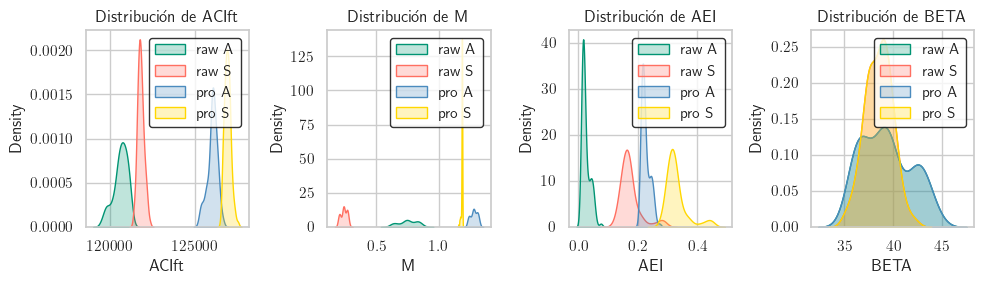

############## SM04 vs G0023 ##############


/var/folders/10/tq6sylxx0k7_f72tbtgslkc00000gn/T/ipykernel_14726/3933873215.py:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


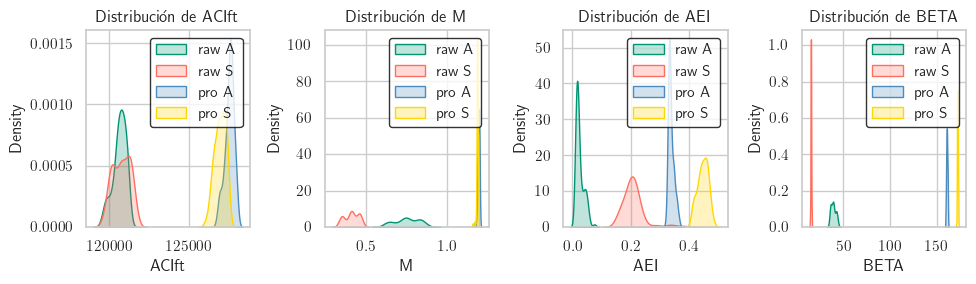

############## SM04 vs G0024 ##############


/var/folders/10/tq6sylxx0k7_f72tbtgslkc00000gn/T/ipykernel_14726/3933873215.py:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


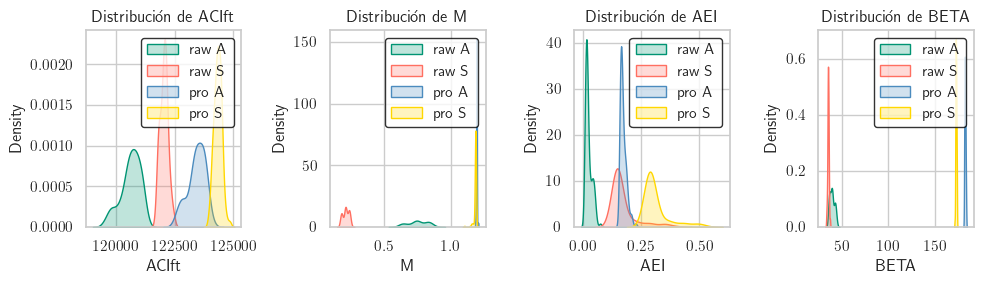

############## SM04 vs G0026 ##############


/var/folders/10/tq6sylxx0k7_f72tbtgslkc00000gn/T/ipykernel_14726/3933873215.py:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


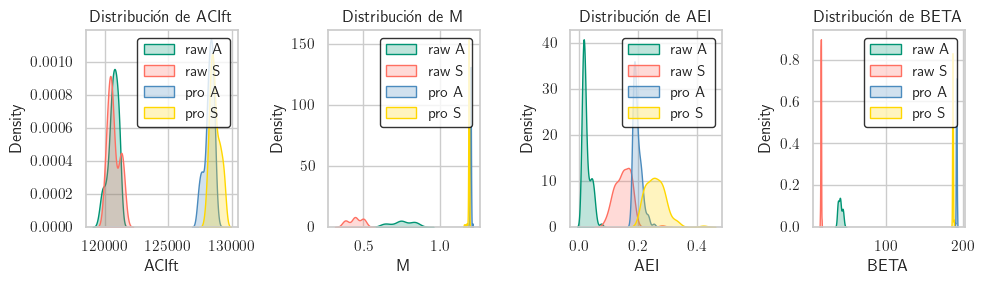

############## SM04 vs G0096 ##############


/var/folders/10/tq6sylxx0k7_f72tbtgslkc00000gn/T/ipykernel_14726/3933873215.py:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


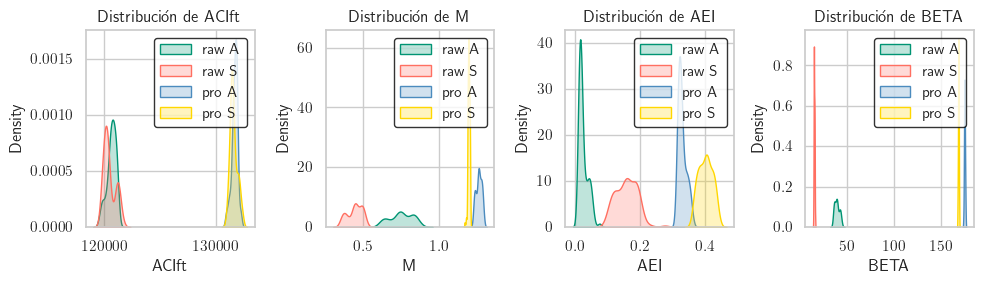

In [5]:
# Configuración de la conexión a la base de datos
conn = sqlite3.connect('../results/results.db')
cursor = conn.cursor()
SIGNAL = "whiteNoise"
BANDWIDTH = 1000
COLS = ['ACIft', 'ADI', 'BETA', 'M', 'NP', 'H', 'AEI', 'NDSI']
reference_folder = 'SM04'

unique_folders = [['G0001','G0002','G0009','G0097'],
                  ['G0020','G0023','G0024','G0026','G0096'],
                  ['G0059','G0068','G0073','G0075','G0080','G0091']]

query = f"SELECT * FROM acoustic_indices WHERE reference_folder = ? AND folder_x = ? AND signal = ? AND bandwidth = ?"

for folder in unique_folders[1]:
    if folder == reference_folder:
        continue
    print(f'############## {reference_folder} vs {folder} ##############')
    df = pd.read_sql_query(query, conn, params=(reference_folder, folder, SIGNAL, BANDWIDTH))
    
    # raw indices
    df1 = blob2df(df.rrf_indices, COLS)
    df2 = blob2df(df.rx_indices, COLS)
    df3 = blob2df(df.prf_indices, COLS)
    df4 = blob2df(df.px_indices, COLS)

    create_custom_color_probability_distribution_subplots([df1, df2, df3, df4], ['raw A', 'raw S', 'pro A', 'pro S'], indices=['ACIft','M','AEI', 'BETA'], figsize=(10, 3), font_size=12)


# Seleccionados SM04 y G0097 v1.0

# figura final

/var/folders/10/tq6sylxx0k7_f72tbtgslkc00000gn/T/ipykernel_14726/1710721525.py:66: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.9)  # Ajustar el espacio superior para evitar solapamiento con los subtítulos
/var/folders/10/tq6sylxx0k7_f72tbtgslkc00000gn/T/ipykernel_14726/1710721525.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=2.3)  # Ajustar el espacio entre subplots


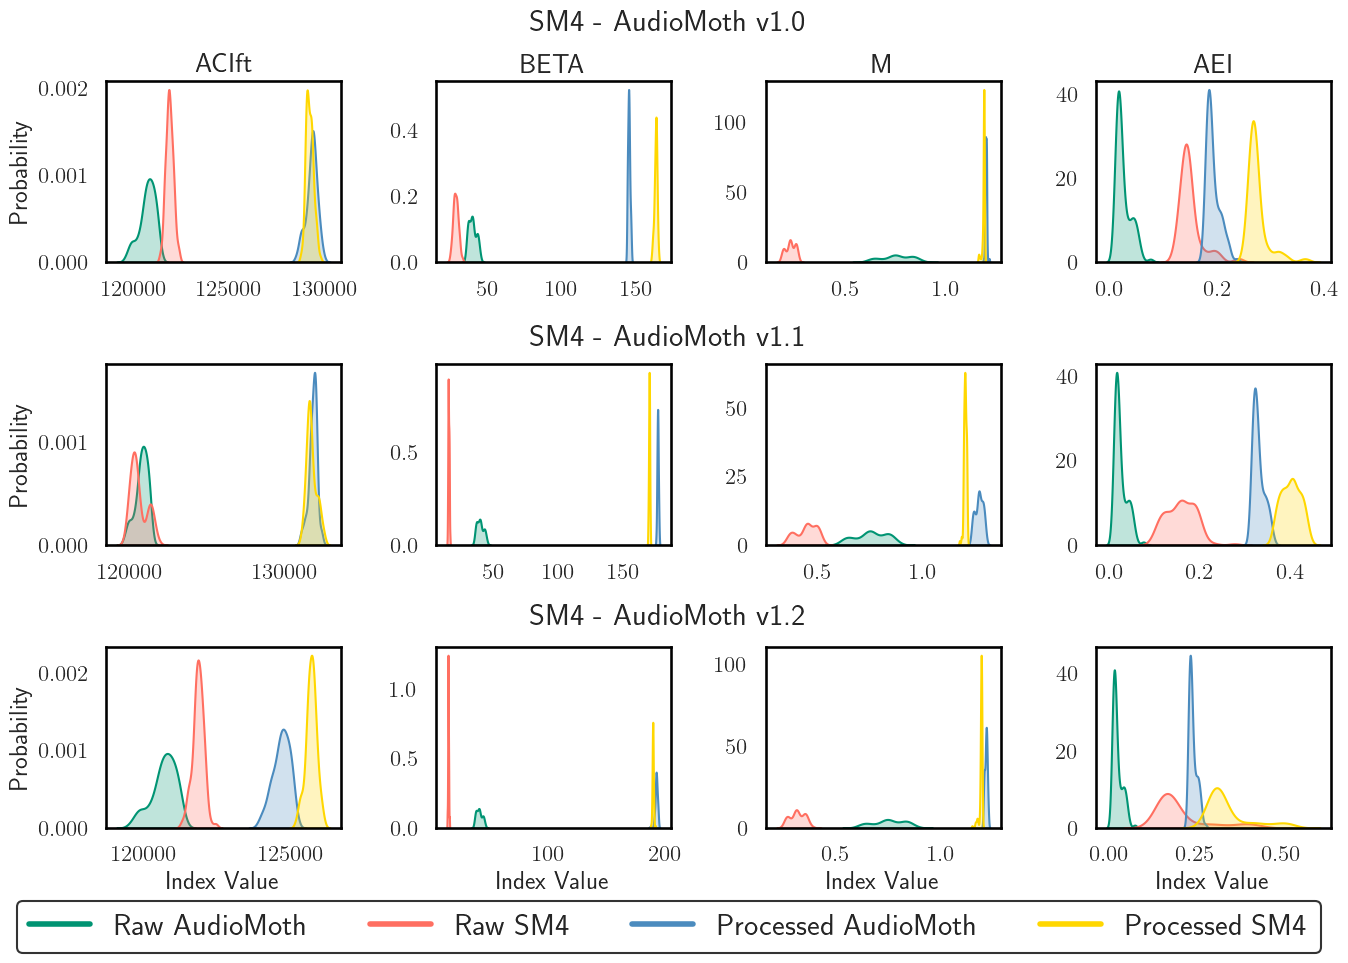

In [117]:
# Configuración de la conexión a la base de datos

from matplotlib.lines import Line2D


conn = sqlite3.connect('../results/results.db')
cursor = conn.cursor()
SIGNAL = "whiteNoise"
BANDWIDTH = 1000
COLS = ['ACIft', 'ADI', 'BETA', 'M', 'NP', 'H', 'AEI', 'NDSI']
COLSPLOT = ['ACIft', 'BETA', 'M','AEI']
custom_palette=['#009473', '#FF6F61', '#4B8BBE', '#FFD700']
reference_folder = 'SM04'

unique_folders = ['G0097','G0096','G0091']

query = f"SELECT * FROM acoustic_indices WHERE reference_folder = ? AND folder_x = ? AND signal = ? AND bandwidth = ?"
subtitles = ['SM4 - AudioMoth v1.0', 'SM4 - AudioMoth v1.1', 'SM4 - AudioMoth v1.2']

sns.set_context("talk")  # 'talk' es un contexto predefinido con un tamaño de fuente más grande


plt.rcParams.update({'font.size': 20, 'axes.facecolor': 'white', 'axes.edgecolor': 'black'})
fig, axs = plt.subplots(3, 4, figsize=(14, 9))
legend_handles = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(custom_palette, ['Raw AudioMoth', 'Raw SM4', 'Processed AudioMoth', 'Processed SM4'])]

for j, folder in enumerate(unique_folders):
    if folder == reference_folder:
        continue
    df = pd.read_sql_query(query, conn, params=(reference_folder, folder, SIGNAL, BANDWIDTH))
    
    # raw indices
    df1 = blob2df(df.rrf_indices, COLS)
    df2 = blob2df(df.rx_indices, COLS)
    df3 = blob2df(df.prf_indices, COLS)
    df4 = blob2df(df.px_indices, COLS)

    dfs = [df1, df2, df3, df4]

    for i, column in enumerate(COLSPLOT):

        sns.kdeplot(df1[column], ax=axs[j][i], fill=True, color=custom_palette[0])
        sns.kdeplot(df2[column], ax=axs[j][i], fill=True, color=custom_palette[1])
        sns.kdeplot(df3[column], ax=axs[j][i], fill=True, color=custom_palette[2])
        sns.kdeplot(df4[column], ax=axs[j][i], fill=True, color=custom_palette[3])

    for i in range(4):
        if i == 0:
            axs[j, i].set_ylabel('Probability')  # Establece la etiqueta del eje Y
        else:
            axs[0,i].set_ylabel(None)
            axs[1,i].set_ylabel(None)
            axs[2,i].set_ylabel(None)
        axs[0, i].set_title(COLSPLOT[i], fontsize=20) 
        axs[0,i].set_xlabel(None)
        axs[1,i].set_xlabel(None)
        axs[2,i].set_xlabel('Index Value')
        axs[j, i].grid(False)

fig.text(0.5, 1, subtitles[0], ha='center', va='center', fontsize=22)
fig.text(0.5, 1 - 0.35, subtitles[1], ha='center', va='center', fontsize=22)
fig.text(0.5, 1 - 0.66, subtitles[2], ha='center', va='center', fontsize=22)


fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4,fontsize=22)
plt.subplots_adjust(top=0.9)  # Ajustar el espacio superior para evitar solapamiento con los subtítulos
plt.tight_layout(h_pad=2.3)  # Ajustar el espacio entre subplots
plt.show()

fig.savefig('../results/figures/indices_comparison.pdf', dpi=300, bbox_inches='tight')

In [22]:
df

,id,reference_folder,folder_x,rrf_indices,prf_indices,rx_indices,px_indices,signal,bandwidth
0,1,SM04,G0091,b'\x80\x04\x95\x0c\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf6\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x0e\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf8\x00\x00\x00\x00\x00\x00\x00...,whiteNoise,1000
1,2,SM04,G0091,b'\x80\x04\x95\x0c\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf6\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x0e\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf8\x00\x00\x00\x00\x00\x00\x00...,whiteNoise,1000
2,3,SM04,G0091,b'\x80\x04\x95\x0c\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf6\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x0e\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf8\x00\x00\x00\x00\x00\x00\x00...,whiteNoise,1000
3,4,SM04,G0091,b'\x80\x04\x95\x0c\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf6\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x0e\x01\x00\x00\x00\x00\x00\x00...,"b""\x80\x04\x95\xf8\x00\x00\x00\x00\x00\x00\x00...",whiteNoise,1000
4,5,SM04,G0091,"b""\x80\x04\x95\x0c\x01\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\xf6\x00\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95\x0e\x01\x00\x00\x00\x00\x00\x00...,"b""\x80\x04\x95\xf8\x00\x00\x00\x00\x00\x00\x00...",whiteNoise,1000
...,...,...,...,...,...,...,...,...,...
1426,11782,SM02,G0096,b'\x80\x04\x95\x0c\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf6\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00]\...,b'\x80\x04\x95\xf7\x00\x00\x00\x00\x00\x00\x00...,chirp,1000
1427,11783,SM02,G0096,b'\x80\x04\x95\x0c\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf6\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x0e\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf8\x00\x00\x00\x00\x00\x00\x00...,chirp,1000
1428,11784,SM02,G0096,b'\x80\x04\x95\x0c\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf6\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\r\x01\x00\x00\x00\x00\x00\x00]\...,b'\x80\x04\x95\xf7\x00\x00\x00\x00\x00\x00\x00...,chirp,1000
1429,11785,SM02,G0096,b'\x80\x04\x95\x0c\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf6\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x0e\x01\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xf8\x00\x00\x00\x00\x00\x00\x00...,chirp,1000
